# Problem Statement: We want to understand how consumer attributes and loan attributes influence tendency of default.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Section 1: Data Cleaning

### 1.1 Load the dataframe and data dictionary

We have a loan dataset and a data dictionary which provides descriptions on each of the variables. Let's read these data into a dataframe below.

In [2]:
original_loan_df = pd.read_csv('loan.csv')
data_dictionary_df = pd.read_excel('Data_Dictionary.xlsx', sheet_name='LoanStats')

We will then create a copy called **loan_df** from the original dataframe **original_loan_df** to work with. As we can see below, this dataset has 39717 observations and 111 columns.

In [3]:
loan_df = original_loan_df.copy()   #create deep copy of original_loan_df
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')
loan_df.head()

No. of observations is 39717 and No. of columns is 111


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Next we will convert our **data_dictionary_df** into a **data_dictionary** in dictionary format so that we can easily see what each variable refers to in a key value pair format. Let's check out a few variables in the **data_dictionary**.

In [4]:
data_dictionary = {}
for i in range(data_dictionary_df.shape[0]):
    data_dictionary[data_dictionary_df.iloc[i, 0]] = data_dictionary_df.iloc[i, 1]

for i, (k, v) in enumerate(data_dictionary.items()):  #print the first 5 key value pairs of data dictionary
    if i < 5:
        print(f'{k}: {v}')

acc_now_delinq: The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths: Number of trades opened in past 24 months.
addr_state: The state provided by the borrower in the loan application
all_util: Balance to credit limit on all trades
annual_inc: The self-reported annual income provided by the borrower during registration.


### 1.2 Identify the Dependent Variable

Referring back to our problem statement, since we have past data about the loan, we can identify the variable of interest which is likely to be the **loan_status**. 

In [5]:
loan_df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

As above, **loan_status** can be classified as 
- **Fully Paid** (this is a clear no default case)
- **Current** (tenure of loan not completed but no default yet)
- **Charge-off** (clear default case)

The question here is whether we should keep the observations for **loan_status** of **Current** type. The number of **Current** loan is 1140 out of a total 39717 observations, about 2.9% of the total observations, still quite a lot of observations. However, we should bear in mind that we cannot ascertain whether this **Current** loans will/will not result in default eventually. So we should exclude these loans from our analysis and not making any assumptions about whether these **Curent** loans is a default or not a default. Let's remove these observations and as we can see below, we are left with 38577 observations now.

In [6]:
loan_df = loan_df.loc[loan_df['loan_status'] != 'Current', :]
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')

No. of observations is 38577 and No. of columns is 111


Now that **loan_status** only takes values of **Fully Paid** and **Charge-off**, we can further create a **default** column which indicates **1** if the loan is charged off and **0** otherwise. The reason for creating a **default** column is to make analysis much easier. Let's first create the **default** column. As we can see below there are 5627 of defaults and 32950 of non-defaults.

In [7]:
loan_df['default'] = loan_df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
loan_df['default'].value_counts()

0    32950
1     5627
Name: default, dtype: int64

Then from below, we can easily see that the average default rate for these loans is **14.59%**.

In [8]:
print('Average default rate is: {}'.format(round((loan_df['default'] == 1).sum() / len(loan_df)*100,2)))

Average default rate is: 14.59


### The dependent variable is default which indicates 1 if default and 0 if non default.

### 1.3 Narrow down the Potential Independent Variables

Now let's deal with our potential independent variables. We still have a large number of columns. Let's see if we can apply some rules to quickly narrow down the number of columns for analysis. Firstly there are many columns which contain all null values and we exclude all of these as below. After excluding columns with all null values, we are left with 57 columns.

In [9]:
loan_df = loan_df.loc[:, loan_df.isnull().sum() < loan_df.shape[0]]
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')

No. of observations is 38577 and No. of columns is 57


Then we identify the columns where there's only one unique value, which means they don't have predictive power at all and we will remove them

In [10]:
non_predictive_cols = []
for col_name in loan_df.columns:
    if len(loan_df[col_name].unique()) == 1:
        non_predictive_cols.append(col_name)
        
non_predictive_cols

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'delinq_amnt']

After removing the non-predictive columns below, we are left with 49 columns.

In [11]:
loan_df = loan_df.iloc[:, ~loan_df.columns.isin(non_predictive_cols)]
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')

No. of observations is 38577 and No. of columns is 49


Now we have a smaller number of columns to work with, but we can still reduce the number of columns by first doing a correlation analysis. We check out the correlation plots below. One of the variables of a highly correlated pair can be dropped because two very highly correlated variables with very similar characteristics are unlikely to add predictive power compared to using just one of the variables of the pair alone).

In [12]:
loan_df.corr().head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,default
id,1.000000,0.993534,0.120614,0.131283,0.231603,0.076088,0.005572,0.091785,-0.008417,-0.041021,...,0.123268,-0.055789,0.038686,-0.010916,0.142251,NaN,NaN,-0.007997,NaN,0.042390
member_id,0.993534,1.000000,0.120393,0.130307,0.241324,0.070918,0.006442,0.092910,-0.007905,-0.045879,...,0.126660,-0.058497,0.036526,-0.012831,0.142582,NaN,NaN,-0.007346,NaN,0.039798
loan_amnt,0.120614,0.120393,1.000000,0.981790,0.937922,0.932260,0.268999,0.062436,-0.031951,0.012940,...,0.728343,0.047103,0.142789,0.077005,0.474614,NaN,NaN,-0.035981,NaN,0.059463
funded_amnt,0.131283,0.130307,0.981790,1.000000,0.956172,0.958035,0.264798,0.062194,-0.031866,0.012857,...,0.736654,0.049465,0.143452,0.078769,0.478448,NaN,NaN,-0.036995,NaN,0.056497
funded_amnt_inv,0.231603,0.241324,0.937922,0.956172,1.000000,0.905464,0.251981,0.070663,-0.038171,-0.002800,...,0.726736,0.029379,0.130997,0.064282,0.469166,NaN,NaN,-0.041193,NaN,0.037781


Sort by highest correlations and drop pairs with duplicate correlation number (assuming that duplicates are the self correlations). Then focus on any variables which have correlation numbers > 0.90 but less than 1.0 (correlation of 1 below is self correlation which we can ignore.

In [13]:
unstacked_corr = loan_df.corr().unstack().sort_values(ascending=False).drop_duplicates()
unstacked_corr[unstacked_corr > 0.90]

default          default            1.000000
id               member_id          0.993534
loan_amnt        funded_amnt        0.981790
total_rec_prncp  total_pymnt        0.973542
total_pymnt_inv  total_pymnt        0.968580
installment      funded_amnt        0.958035
funded_amnt_inv  funded_amnt        0.956172
total_pymnt_inv  total_rec_prncp    0.940299
loan_amnt        funded_amnt_inv    0.937922
                 installment        0.932260
funded_amnt_inv  total_pymnt_inv    0.909127
                 installment        0.905464
dtype: float64

We will remove one of the variables in a highly correlated pair. After checking on the **Data_Dictionary**, the variables from these highly correlated pairs that we have decided to remove are <i>out_prncp_inv, member_id, funded_amnt, total_rec_prncp, total_pymnt_inv, funded_amnt_inv, installment<i>. After removal, we are left with 43 columns as below.

In [14]:
cols_to_remove = ['out_prncp_inv', 'member_id', 'funded_amnt', 'total_rec_prncp', 
                  'total_pymnt_inv', 'funded_amnt_inv', 'installment']

loan_df = loan_df.iloc[:, ~loan_df.columns.isin(cols_to_remove)]
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')

No. of observations is 38577 and No. of columns is 43


So far we have dropped columns based on more quantitative rules such as removing columns which only have 1 type of unique values thus has no predictive power, removing columns which only have null values, removing columns which are very highly correlated with other columns and have very similar characteristics (e.g preserving the **loan_amnt** but dropping the **funded_amnt**). To be able to drop columns further, we need to have more understanding on what the remaining columns represent. Let's check out what are the remaining columns that we have in the **loan_df** and use the **data_dictionary** to check the description as below.

In [15]:
for col_name in loan_df.columns:
    if col_name == 'default':
        print(f'{col_name}: Indicator whether the loan is in default, 1 for default and 0 for no default)')
    else:
        print(f'{col_name}: {data_dictionary[col_name]}')

id: A unique LC assigned ID for the loan listing.
loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
term: The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate: Interest Rate on the loan
grade: LC assigned loan grade
sub_grade: LC assigned loan subgrade
emp_title: The job title supplied by the Borrower when applying for the loan.*
emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
annual_inc: The self-reported annual income provided by the borrower during registration.
verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
issue_d: The mon

- Since we want to find out variables which are driving factors behind loan default to make business decisions whether to approve/reject a loan application, we can drop **Customer behaviour variables** which can't be used to drive decision at loan inception such as **delinq_2yrs, mths_since_last_delinq, mths_since_last_record, pub_rec, revol_bal, revol_util, total_pymnt, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, chargeoff_within_12_mths, next_pymnt_d, pub_rec_bankruptcies**. 
- **url** for each loan is not accessible so we remove.
- We can drop the **loan_status** column already since we already derived a new column **default** which is our main variable of interest.

Checking at some of the variables again, notice that some have only unique values of 0 and null, which means these should be removed also. Example below:

In [16]:
loan_df.tax_liens.unique()

array([ 0., nan])

Let's loop through all columns and check again which columns only have unique values of 0 and null

In [17]:
for col_name in loan_df.columns:
    if (loan_df[col_name].unique()[0] == 0 and str(loan_df[col_name].unique()[1]) == 'nan'):
        print(col_name)

collections_12_mths_ex_med
chargeoff_within_12_mths
tax_liens


Below we further drop the columns we have just discussed above.

In [18]:
further_cols_to_drop = ['delinq_2yrs', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec',
                        'revol_bal', 'revol_util', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee',
                        'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
                        'last_credit_pull_d', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
                        'next_pymnt_d', 'pub_rec_bankruptcies', 'url','tax_liens','loan_status']

loan_df = loan_df.iloc[:, ~loan_df.columns.isin(further_cols_to_drop)]
print(f'No. of observations is {loan_df.shape[0]} and No. of columns is {loan_df.shape[1]}')

No. of observations is 38577 and No. of columns is 23


Now we are left with 23 columns (**22 potential independent variables and 1 dependent variable**), much more manageable than the 111 columns. We can start to really analyze the data.

- **We are proceeding with the following two types of analysis of the cleaned data:**<br>
**i** Univariate Analysis-I (analysis of individual columns and dependent variable)<br>
**ii** Bivariate Analysis (analysis of multiple predictor variables and dependent variable)<br><br>

- **Assumptions:**<br>
**i.** We have assumed that Current loans can not be judged as of now and hence the analysis is only done for those LC customers who have either defaulted or fully paid their loans. <br>
**ii.** We assume that Customer Behaviour Variables tell about the customer behaviour only after the issuance of loan and hence we would do our analysis on only those variables which LC obtains/derives prior to issuance of loans.

## Section 2: Univariate Analysis-I

We start with Univariate Analysis. Let's check out the remaining columns and their description.

In [19]:
for col_name in loan_df.columns:
    if col_name == 'default':
        print(f'{col_name}: Indicator whether the loan is in default, 1 for default and 0 for no default)')
    else:
        print(f'{col_name}: {data_dictionary[col_name]}')

id: A unique LC assigned ID for the loan listing.
loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
term: The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate: Interest Rate on the loan
grade: LC assigned loan grade
sub_grade: LC assigned loan subgrade
emp_title: The job title supplied by the Borrower when applying for the loan.*
emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
annual_inc: The self-reported annual income provided by the borrower during registration.
verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
issue_d: The mon

### 2.1 Loan Amount

Let's have a look at the distribution of the loan amount.

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


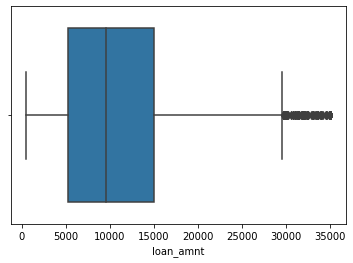

In [20]:
print(loan_df['loan_amnt'].describe())
sns.boxplot(loan_df['loan_amnt'])
plt.show()

There are no missing values in this column. Further, we can see loans given out by LendingClub are generally quite small as compared to mortage or auto-loans. 50% of loans lie between 5300 dollars(25th percentile) and 15000 dollars (75th percentile). 50% of loans are below 9600 dollars (median) and the average loan amount given is 11047 dollars.

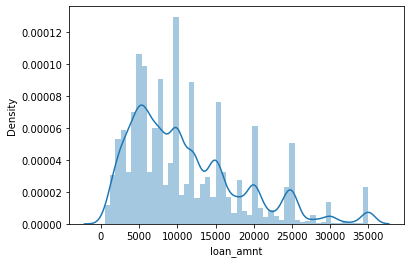

In [21]:
sns.distplot(loan_df.loan_amnt)
plt.show()

In [22]:
loan_df.loan_amnt.value_counts().sort_values(ascending=False).head(10)

10000    2809
12000    2248
5000     2028
6000     1886
15000    1838
8000     1568
20000    1536
25000    1327
4000     1123
3000     1018
Name: loan_amnt, dtype: int64

We can also see frequency of the loan amounts given tend to spike at the multiple of 5000, which is quite common given that borrowers normally apply for loans in muliples of 5000 for small loan amounts. As seen below, loan amount of 5000, 10000, 15000, 20000 and 25000 are popular.

Based on the plot above, let's derive a categorical loan amount variable with 4 fixed sized bins (0-5000, 5000-10000, 10000-15000 and 15000 and above).

In [23]:
loan_df['loan_amnt_category'] = pd.cut(loan_df.loan_amnt, [0,5000,10000,15000,35000], 
                                      labels=['0.5-5k', '5-10k', '10-15k', '15-35k'])
loan_df['loan_amnt_category'].value_counts()

5-10k     12802
0.5-5k     9472
15-35k     8620
10-15k     7683
Name: loan_amnt_category, dtype: int64

loan_amnt_category
0.5-5k    0.138725
5-10k     0.128261
10-15k    0.137316
15-35k    0.187471
Name: default, dtype: float64


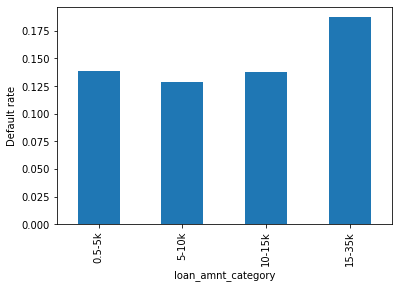

In [24]:
print(loan_df.groupby('loan_amnt_category')['default'].mean())
loan_df.groupby('loan_amnt_category')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

Big loan amounts (loans above 15000) have the highest average default rate of 18.75%, as compared to loan amount of less than 5000, 5000 to 10000, and 10000 to 15000 with average default rate of 13.87%, 12.83% and 13.73% respectively.

### 2.2 Loan Tenure (Term)

In [25]:
loan_df.term.describe()

count          38577
unique             2
top        36 months
freq           29096
Name: term, dtype: object

We notice that there are no missing values in this column.

Percentage of loans
  36 months    0.754232
 60 months    0.245768
Name: term, dtype: float64


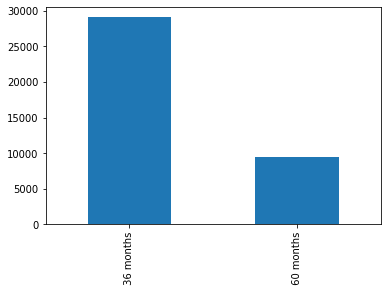

In [26]:
print('Percentage of loans\n', loan_df.term.value_counts(normalize=True))
loan_df.term.value_counts().plot.bar()
plt.show()

As above there are only 2 types of loans given by LendingClub, **36 months** loan and **60 months** loan where 75.4% of the loans are 36 months loan and 24.6% of the loans are 60 months loan.

term
 36 months    0.110909
 60 months    0.253138
Name: default, dtype: float64


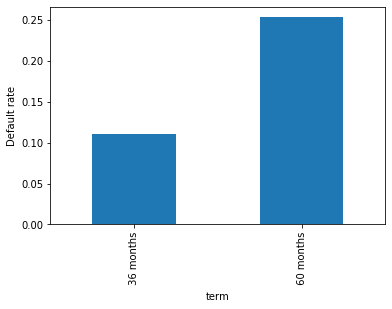

In [27]:
print(loan_df.groupby('term')['default'].mean())
loan_df.groupby('term')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

As seen above, loans with long term tenure (60 months) has a higher than average default rate of 25.31%, whereas loans with shorter term tenure (36 months) has a lower than average default rate of 11.09%.

### 2.3 Interest rate:

In [28]:
loan_df.int_rate.describe()

count      38577
unique       370
top       10.99%
freq         913
Name: int_rate, dtype: object

There are no missing values in this column. Lets bring the data into proper format.

In [29]:
loan_df['int_rate']=loan_df.int_rate.apply(lambda x:float(x[:-1]))     #convert object to float

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64


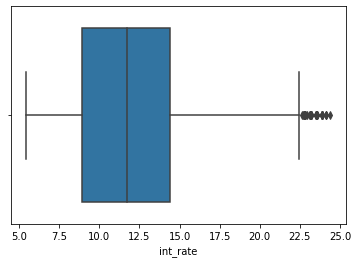

In [30]:
print(loan_df.int_rate.describe())
sns.boxplot(loan_df.int_rate)
plt.show()

From the above, we know that 50% of the LC customers have be offered interest rates up to 11.71%. The interest rate offered by LC is in the range of 5.42% to 24.4%. Lets checkout the statistical description of interest rates of default and fully paid loans.

Interest rate description of default loans:
 count    5627.000000
mean       13.820432
std         3.654413
min         5.420000
25%        11.310000
50%        13.610000
75%        16.400000
max        24.400000
Name: int_rate, dtype: float64
Interest rate description of fully paid loans:
 count    32950.000000
mean        11.609761
std          3.599964
min          5.420000
25%          8.490000
50%         11.490000
75%         13.990000
max         24.110000
Name: int_rate, dtype: float64


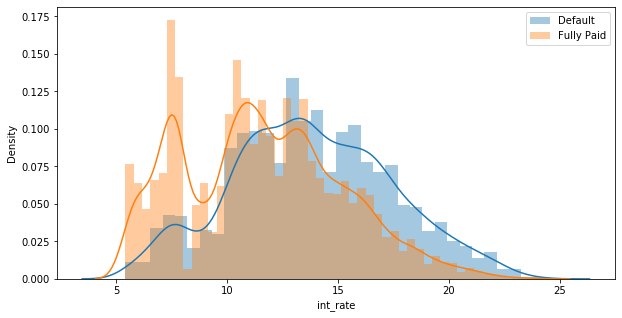

In [31]:
print('Interest rate description of default loans:\n', loan_df[loan_df.default==1].int_rate.describe())
print('Interest rate description of fully paid loans:\n', loan_df[loan_df.default==0].int_rate.describe())
plt.figure(figsize=(10,5))
sns.distplot(loan_df[loan_df.default==1].int_rate,label='Default')
sns.distplot(loan_df[loan_df.default==0].int_rate,label='Fully Paid')
plt.legend()
plt.show()

From the above, we may notice that the distribution of the interest rate of default loans is approximately uniform while that of fully paid loans is peaky and right skewed. The same indicates that default loans have been charged relatively higher interest rates as compared to the fully paid loans.

Lets categorize this column into L (5.4-9), ML (9-12), MH (12-15) & H (15-25) for further analysis.

In [32]:
loan_df['int_rate_category']=pd.cut(loan_df.int_rate,[5.4,9,12,15,25])

int_rate_category
(5.4, 9.0]      0.059645
(9.0, 12.0]     0.120796
(12.0, 15.0]    0.165423
(15.0, 25.0]    0.261381
Name: default, dtype: float64


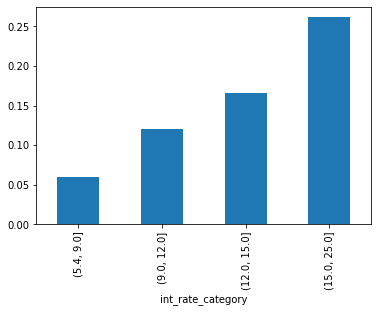

In [33]:
print(loan_df.groupby('int_rate_category').default.mean())
loan_df.groupby('int_rate_category').default.mean().plot.bar()
plt.show()

From the above we can clearly see that as interest rate on loan increases, default rate increases.

### 2.4 Grade:

LC issues grade to applications before the issuance of loans, **A** being the best and **G** being the worst.

In [34]:
loan_df.grade.describe()

count     38577
unique        7
top           B
freq      11675
Name: grade, dtype: object

We do not have any missing values in this column. Lets checkout the corresponding value counts.

B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64


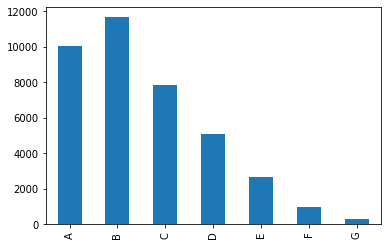

In [35]:
print(loan_df.grade.sort_index().value_counts())
loan_df.grade.value_counts().sort_index().plot.bar()
plt.show()

From the above, we can tell in general that higher the loan rating, better is the chance of conversion of loan application into actual loan. B type loans are highest in count, which is understandable as fewer loan applications have been issued perfect grade.

Both Grade and Default are categorical variables. Lets create pivot table to better visualize the relatioship between the two.

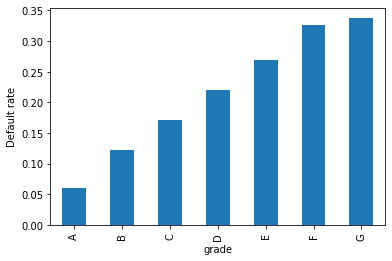

In [36]:
loan_df.groupby('grade').default.mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

From the earliers, we know that count of low grade loans are relatively less but still the above higher percentage of charged off at low grades cant be ignored. Hence from the above barplot, we can establish the relation that as the grade rating of the loan application decreases, the default rate increases. 

### 2.5 Sub-Grade:

Each of the grade has total 05 subgrades to fine-scale the ratings, **A1** being the best and **A5** being the worst under grade **A**. LC issues sub-grade to applications before the issuance of loans. Lets checkout this column.

In [37]:
loan_df.sub_grade.describe()

count     38577
unique       35
top          A4
freq       2873
Name: sub_grade, dtype: object

No value is missing in this column. Lets check the value counts of different sub-grade.

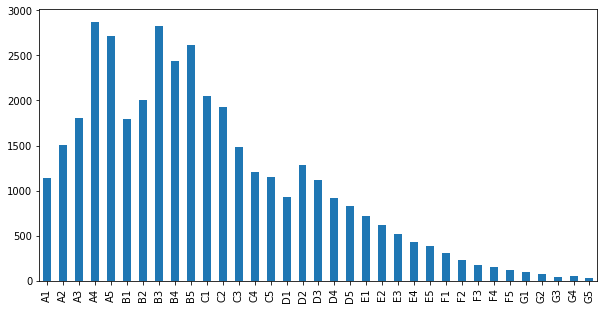

In [38]:
plt.figure(figsize=(10,5))
loan_df.sub_grade.value_counts().sort_index().plot.bar()
plt.show()

From above, we can ofcourse say that higher is the rating, better is the chance of loan conversion. If we look closely, we can notice that the plot is right skewed, which may be due to the reason that very few loan applications are generally given perfect scores.

Just like Grade predictor, lets also create a bar plot for sub-grade and default variables to visualize the relationship.

sub_grade
A1    0.026339
A2    0.049072
A3    0.056906
A4    0.061956
A5    0.079926
B1    0.095159
B2    0.113943
B3    0.120708
B4    0.135002
B5    0.136138
C1    0.163504
C2    0.166235
C3    0.181452
C4    0.175788
C5    0.180243
D1    0.179377
D2    0.210731
D3    0.229391
D4    0.234205
D5    0.250600
E1    0.274238
E2    0.265472
E3    0.230620
E4    0.297170
E5    0.281654
F1    0.298361
F2    0.300429
F3    0.293103
F4    0.350993
F5    0.477876
G1    0.329787
G2    0.363636
G3    0.422222
G4    0.240741
G5    0.344828
Name: default, dtype: float64


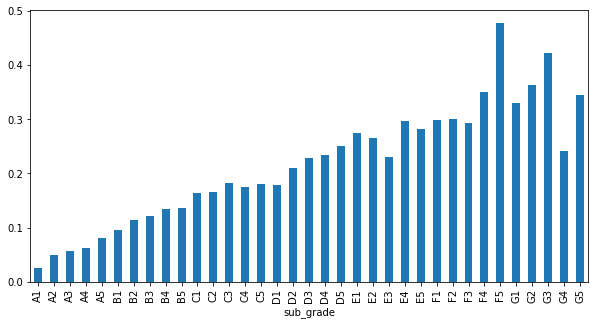

In [39]:
print(loan_df.groupby('sub_grade').default.mean())
plt.figure(figsize=(10,5))
loan_df.groupby('sub_grade').default.mean().plot.bar()
plt.show()

From the above plots, we can interpret that the default rate increases as the loan sub-grade gets worst. However, we should keep it in mind that the no. of issued loans in the worst sub-grade categories are very less. Hence, grade seem more reliable predictor to judge the default rate.

### 2.6 Job Title

In [40]:
print(f'No. of loans where borrowers did not provide a job title: {loan_df.emp_title.isnull().sum()}')
print(f'There are {len(loan_df.emp_title.unique())} unique job titles')
loan_df.emp_title.value_counts().head(10)

No. of loans where borrowers did not provide a job title: 2386
There are 28028 unique job titles


US Army              131
Bank of America      107
IBM                   65
AT&T                  57
Kaiser Permanente     56
Wells Fargo           52
UPS                   52
USAF                  52
US Air Force          51
Walmart               45
Name: emp_title, dtype: int64

There are **2386** missing values in this column. Instead of imputing them, we can categorise them as group of customers who do not declare their job titles while filling the loan applications.

In [41]:
round(loan_df[loan_df.emp_title.isna()==True].default.mean()*100,2)

20.28

In [42]:
round(loan_df[loan_df.emp_title.isna()==False].default.mean()*100,2)

14.21

From the above, we notice that those customers who do not declare their job title while filling the loan application have relatively higher default rate of **20.28%** as compared with those who declare their job title (**14.21%**).

For further analysis, we can see above that there are too many unique job titles (28028 of them) out of 39717 observations, which means we may need to further group them into smaller groups such as different industries if we wish to analyze this independent variable. However since the futher information on industries classification is not available to us, we skip this variable.

### 2.7 Employment Length

In [43]:
loan_df.emp_length.describe()

count         37544
unique           11
top       10+ years
freq           8488
Name: emp_length, dtype: object

Number of loan applications which did not indicate an employment length: 1033


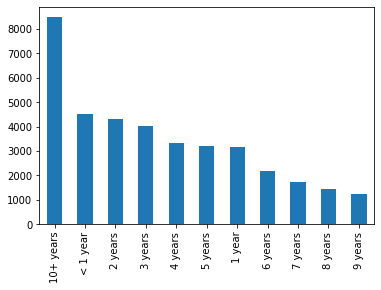

In [44]:
print('Number of loan applications which did not indicate an employment length: {}'.format(loan_df.emp_length.isnull().sum()))
loan_df.emp_length.value_counts().plot.bar()
plt.show()

From above, we see that loans are given to all sorts of customers with different employment length.

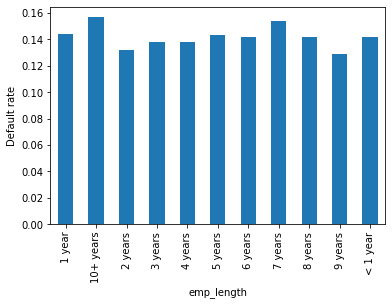

In [45]:
loan_df.groupby('emp_length')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

Surprisingly borrowers with employment history of more than 10 years have a slightly higher than average default rate. However, as seen above, there's no clear trend whether employment history has a positive/negative relationship with the default rate. Further from previously there are 1033 loan applications which did not specify the employment length. Let's look at the default rate of this group of loan applications. 

In [46]:
no_employment_history = loan_df[loan_df['emp_length'].isnull() == True]['default'].mean() * 100
print('Average default rate for loans which did not specify employment history: {:.2f}%'.format(no_employment_history))

Average default rate for loans which did not specify employment history: 22.07%


The average default rate for loans where borrowers did not specify employment history is very high at 22.07%

### 2.8 Home Ownership

In [47]:
loan_df.home_ownership.describe()

count     38577
unique        5
top        RENT
freq      18480
Name: home_ownership, dtype: object

There are no missing values in this column. Further, there are 3 main categories of home ownership, either the borrower currently rents a place (RENT), or has an existing mortgage (MORTGAGE) or already fully paid off and own the home (OWN). The rest is (OTHER) or (NONE).

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64


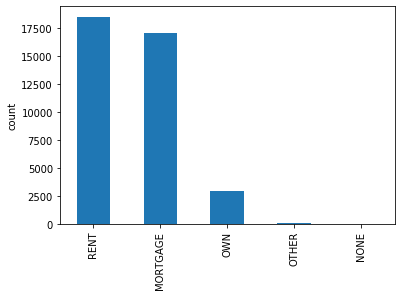

In [48]:
print(loan_df['home_ownership'].value_counts())
loan_df['home_ownership'].value_counts().plot.bar()
plt.ylabel('count')
plt.show()

Majority of of the loan borrowers are renting or have a mortgage on their home.

home_ownership
MORTGAGE    0.136713
NONE        0.000000
OTHER       0.183673
OWN         0.148908
RENT        0.153626
Name: default, dtype: float64


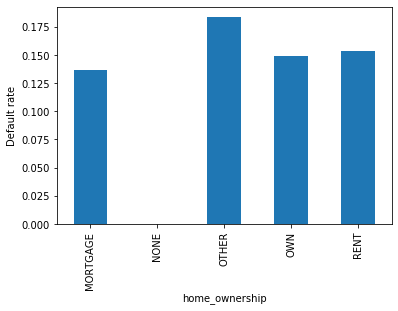

In [49]:
print(loan_df.groupby('home_ownership')['default'].mean())
loan_df.groupby('home_ownership')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

We do know from univariate analysis that number of loans with home ownership specified as 'OTHER' and 'NONE' are only very few, 98 for 'OTHER' and 3 for 'NONE' which makes up only 0.25% of the observations, so let's not make any judgement on these two groups. We can see that loans where home ownership is 'RENT' has a slightly higher than average default rate of 15.36%.

### 2.9 Annual Income

In [50]:
loan_df.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

There are no missing values in this column. We can see that the median income of the loan borrowers is 58,868 dollars while 50% of the income range from 40,000 dollars (25th percentile) to 82,000 dollars (75th percentile).

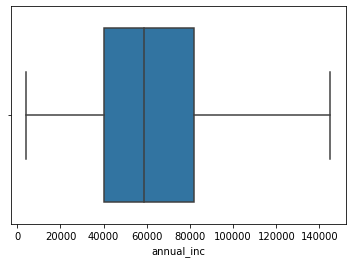

In [51]:
sns.boxplot(loan_df.annual_inc, showfliers=False) #showfliers=False to exclude outliers in the boxplot
plt.show()

From above we can categorize annual income into 4 fixed bins, Low Income for less than 40,000 earnings, Medium Low Income for 40,000 to 60,000 earnings, Medium High Income for 60,000 to 80,000 earnings and High Income for more than 80,000 earnings.

annual_inc_category
<=40k      9698
40-60k    11263
60-80k     7621
>80k       9995
Name: default, dtype: int64


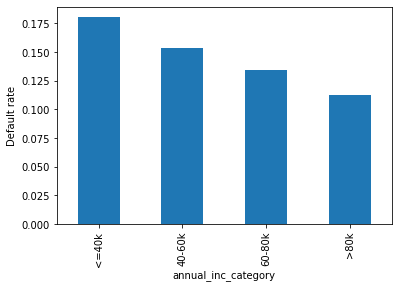

In [52]:
loan_df['annual_inc_category'] = pd.cut(loan_df['annual_inc'], 
                                        [0, 40000, 60000, 80000, 6000001], 
                                        labels=['<=40k', '40-60k', '60-80k', '>80k'])

loan_df.groupby('annual_inc_category')['default'].mean().plot.bar()
plt.ylabel('Default rate')
print(loan_df.groupby('annual_inc_category')['default'].count())
plt.show()

Clearly we can observe a rather strong negative linear relationship between annual income and tendency to default (i.e higher the annual income the less likely is the loan to default).

### 2.10 Verification Status

In [53]:
loan_df.verification_status.describe()

count            38577
unique               3
top       Not Verified
freq             16694
Name: verification_status, dtype: object

There are no missing values in this column. Verification status indicates whether the loan borrower's income is verified, not verified or their source of income is verified by some third party.

Verification status of the loan
 Not Verified       16694
Verified           12206
Source Verified     9677
Name: verification_status, dtype: int64


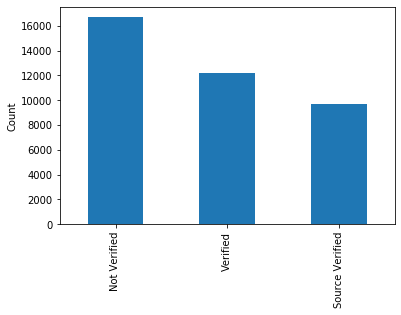

In [54]:
print('Verification status of the loan\n', loan_df.verification_status.value_counts())
loan_df.verification_status.value_counts().plot.bar()
plt.ylabel('Count')
plt.show()

As seen below, 43.3% of borrower's income was not verified in any way. 

In [55]:
round(len(loan_df[loan_df.verification_status == 'Not Verified']) / len(loan_df)*100,1)

43.3

verification_status
Not Verified       0.128310
Source Verified    0.148186
Verified           0.168032
Name: default, dtype: float64


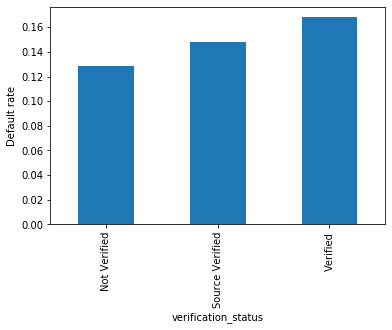

In [56]:
print(loan_df.groupby('verification_status')['default'].mean())
loan_df.groupby('verification_status')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

The results are slightly counter-intuitive. Borrowers with verified income have higher than average default rate of 16.80%, while borrowers where their income are not verified at all have a lower than average default rate of 12.83%. The reason could be LendingClub does not see a need to verify the borrower's income due to an already strong credit profile or there might be flaw in LC's income verification process. We can further say that the third party has done good job in income verification, if we consider default rate a metric.

### 2.11 Issue Date

This corresponds to the month-year when the loan was issued. 

In [57]:
loan_df.issue_d.describe()

count      38577
unique        55
top       Nov-11
freq        2062
Name: issue_d, dtype: object

No missing values are there in this column.

In [58]:
loan_df['issue_d'].unique()

array(['Dec-11', 'Nov-11', 'Oct-11', 'Sep-11', 'Aug-11', 'Jul-11',
       'Jun-11', 'May-11', 'Apr-11', 'Mar-11', 'Feb-11', 'Jan-11',
       'Dec-10', 'Nov-10', 'Oct-10', 'Sep-10', 'Aug-10', 'Jul-10',
       'Jun-10', 'May-10', 'Apr-10', 'Mar-10', 'Feb-10', 'Jan-10',
       'Dec-09', 'Nov-09', 'Oct-09', 'Sep-09', 'Aug-09', 'Jul-09',
       'Jun-09', 'May-09', 'Apr-09', 'Mar-09', 'Feb-09', 'Jan-09',
       'Dec-08', 'Nov-08', 'Oct-08', 'Sep-08', 'Aug-08', 'Jul-08',
       'Jun-08', 'May-08', 'Apr-08', 'Mar-08', 'Feb-08', 'Jan-08',
       'Dec-07', 'Nov-07', 'Oct-07', 'Sep-07', 'Aug-07', 'Jul-07',
       'Jun-07'], dtype=object)

We can see that the loans were issued from Jun 2007 to Dec 2011. To simplify our analysis of this column, we can group them into different years and months.

In [59]:
loan_df['issue_d']=pd.to_datetime(loan_df['issue_d'],format='%b-%y')

In [60]:
loan_df['issue_d'].dt.year.value_counts().sort_index()

2007      251
2008     1562
2009     4716
2010    11532
2011    20516
Name: issue_d, dtype: int64

Most of the loans are issued in year 2011.

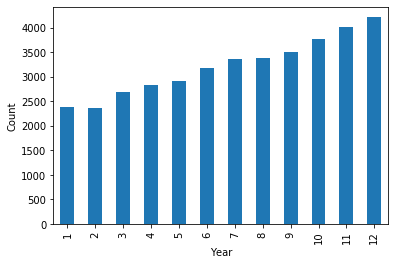

In [61]:
loan_df['issue_d'].dt.month.value_counts().sort_index().plot.bar()
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

From the above we note that the total no. of loans issued by LC in a month increases from year starting month (Jan) to year ending month (Dec).

Lets checkout default rates for the loans issued during different years.

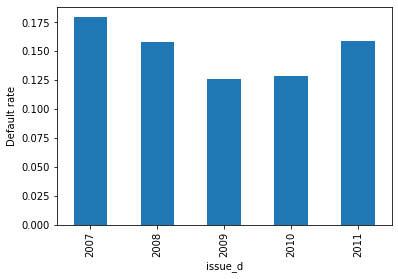

In [62]:
loan_df.groupby(loan_df.issue_d.dt.year).default.mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

From the above, we do not see any pattern in default rates for loans issued in different years. Lets check for the default rates for the loans issued in different months.

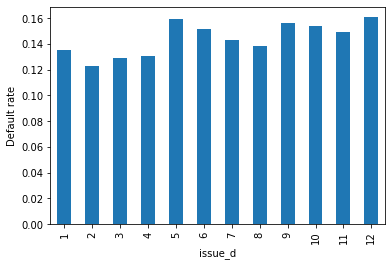

In [63]:
loan_df.groupby(loan_df.issue_d.dt.month).default.mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

- from the above, we can not figure out any pattern which indicate default.
- we skip this variable as this should be a business decision to decide whether to be more aggressive giving out loans during different periods based on the economic environment.

### 2.12 Description of the Loan

In [64]:
print('No. of missing values in description: {}'.format(loan_df['desc'].isnull().sum()))

No. of missing values in description: 12527


This is a loan description provided by borrower. As seen below, some provided long descriptions and some just give a very short and general description. 

In [65]:
print(loan_df['desc'].value_counts().sort_values(ascending=False).head(5))
print(loan_df['desc'].value_counts().sort_values(ascending=True).head(5))

                                  209
Debt Consolidation                  8
Camping Membership                  6
credit card debt consolidation      3
Personal Loan                       3
Name: desc, dtype: int64
  Borrower added on 12/18/09 > My husband and I had a very successful insurance brokerage.  He was diagnosed with cancer about two years ago, which forced us to close the business, and depleted our savings.  However, he survived his chemotherapy and radiation treatments, has regained his strength and is ready to get back to what he does best.  This money is to help us reopen our office and to give us initial operating and marketing capital.  The best part about this is that my husband is a fantastic financial advisor and is looking forward to later in 2010 when we can not only finish paying off the loan, but become investors ourselves.<br/>    1
  Borrower added on 12/28/09 > I plan on using the loan to buy a used car from a dealership. I am a good borrower because I can mak


Let us create word count column for our further analysis on this column. Our rationale behind the same is that more no. of words used by borrower in the description column of it's loan application might depict the sincere intention and commitment. No harm in checking out this derived metric to validate out assumption.

In [66]:
#create desc word count column 
loan_df['desc_len']=loan_df.desc.apply(lambda x: len(x.split(' ')) if type(x)==str else 0)  

In [67]:
loan_df.desc_len.describe()

count    38577.000000
mean        54.428986
std         79.039510
min          0.000000
25%          0.000000
50%         28.000000
75%         75.000000
max       1060.000000
Name: desc_len, dtype: float64

In [68]:
loan_df['desc_len_category']=pd.cut(loan_df.desc_len,[0,28,75,1060])   #categorization of different word counts

In [69]:
loan_df['desc_len_category'].value_counts()

(75, 1060]    9565
(28, 75]      9414
(0, 28]       7071
Name: desc_len_category, dtype: int64

desc_len_category
(0, 28]       0.152878
(28, 75]      0.150096
(75, 1060]    0.139153
Name: default, dtype: float64


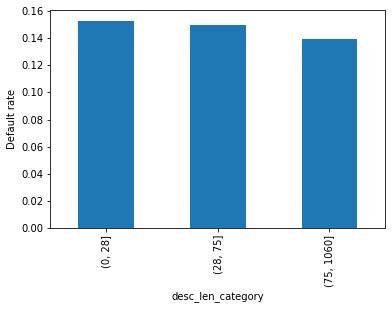

In [70]:
print(loan_df.groupby('desc_len_category').default.mean())
loan_df.groupby('desc_len_category').default.mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

From the above we notice that those borrower who have used less words **(0 to 75)** in description of columns of their loan applications have higher than average default rate. We may further go ahead with sentiment analysis of this column.

### 2.13 Loan Purpose

This is the category chosen by borrower specifying the loan purpose

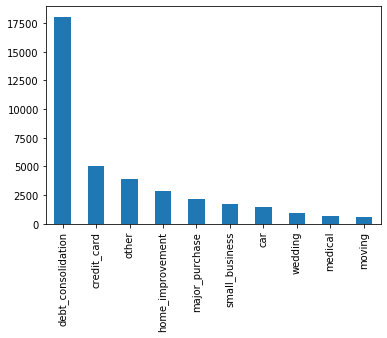

In [71]:
loan_df['purpose'].value_counts().head(10).plot.bar()
plt.show()

As seen above, majority of the loans are used for debt consolidation, followed by settling credit card debts, other purpose, home improvement, major purchases and small business.

purpose
small_business        0.270810
renewable_energy      0.186275
educational           0.172308
other                 0.163777
house                 0.160763
moving                0.159722
medical               0.155653
debt_consolidation    0.153254
vacation              0.141333
home_improvement      0.120696
credit_card           0.107818
car                   0.106738
wedding               0.103672
major_purchase        0.103256
Name: default, dtype: float64


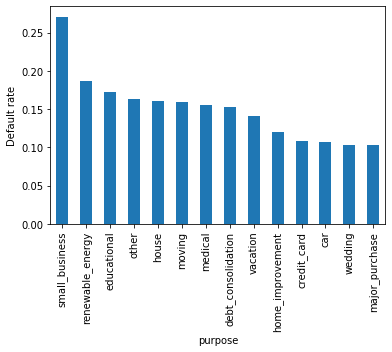

In [72]:
print(loan_df.groupby('purpose')['default'].mean().sort_values(ascending=False))
loan_df.groupby('purpose')['default'].mean().sort_values(ascending=False).plot.bar()
plt.ylabel('Default rate')
plt.show()

Surprisingly, borrowers who get a loan to pay off credit card only has a 10.78% average default rate, much lower than the average default rate for all loans of 14.59%. Borrowers who get a loan to consolidate debts has an average default rate of 15.33% slightly higher than the average default rate of 14.59%. Perhaps not surprisingly, the **riskiest loan** with the highest average default rate is **Small Business** with a 27.08% average default rate! Borrowers who do not wish to specify their purpose of getting a loan (classified as 'other') also has a higher than average default rate of 16.38%.

### 2.14 Loan Title

This is the loan title provided by the borrower.

In [73]:
print(loan_df['title'].value_counts().head(10))

Debt Consolidation           2090
Debt Consolidation Loan      1620
Personal Loan                 641
Consolidation                 491
debt consolidation            478
Credit Card Consolidation     348
Home Improvement              345
Debt consolidation            322
Small Business Loan           305
Personal                      301
Name: title, dtype: int64


This column is actually quite similar to loan purpose but there are many overlaps in category such as debt consolidation and debt consolidation loan, credit card consolidation and credit card loan etc. So we will avoid using this column for further analysis (since it is similar to loan purpose but has overlapping categories).

### 2.15 Zip Code

This is the zip code of the borrower's address.

In [74]:
unique_zip_codes = len(loan_df['zip_code'].unique())
print(f'Number of unique zip codes is: {unique_zip_codes}')

Number of unique zip codes is: 822


In [75]:
loan_df['zip_code'].value_counts().head()

100xx    583
945xx    531
112xx    502
606xx    493
070xx    455
Name: zip_code, dtype: int64

In [76]:
loan_df['zip_code'].value_counts().tail()

375xx    1
266xx    1
369xx    1
463xx    1
388xx    1
Name: zip_code, dtype: int64

As seen above, there are 822 unique zip codes and some of the zip codes only have 1 loan given out. If we want to analyze zip code further, we will need to group them into similar locations. We will skip this as we prefer to analyze 'Address State' which is easier to analyze with only 50 unique States as compared to zip codes with 822 unique values.

### 2.16 Address State

This is the State specified by the borrower in loan application

In [77]:
unique_states = len(loan_df['addr_state'].unique())
print(f'No. of unique states is: {unique_states}')

No. of unique states is: 50


Since the number of unique States is much smaller (50 of them) as compared to the number of zip codes (822), it is a column easier to analyze if we want to find out later if any borrowers who come from some specific States are more prone to default.

In [78]:
loan_df.addr_state.value_counts().head()

CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
Name: addr_state, dtype: int64

In [79]:
loan_df.addr_state.value_counts().tail()

IN    9
ID    6
NE    5
IA    5
ME    3
Name: addr_state, dtype: int64

However, we can see that some of the states only have very few counts of data. Let's categorize the states based on the US Census Bureau's region definition. US Census Bureau categorizes states into 4 main regions (West, Midwest, Northeast and South). https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [80]:
west = ['WA', 'OR', 'ID', 'MT', 'WY', 'CA', 'NV', 'UT', 'CO', 'AZ', 'NM', 'AK', 'HI']
mid_west = ['ND', 'SD', 'MN', 'NE', 'IA', 'KS', 'MO', 'WI', 'MI', 'IL', 'IN', 'OH']
north_east = ['NY', 'PA', 'NJ', 'VT', 'NH', 'MA', 'CT', 'RI', 'ME']
south = ['OK', 'TX', 'AR', 'LA', 'MS', 'AL', 'KY', 'TN', 'GA', 'FL', 'WV', 'MD', 'DC', 'DE', 'VA', 'NC', 'SC']

In [81]:
def region(addr_state):
    if addr_state in west:
        return 'West'
    elif addr_state in mid_west:
        return 'Midwest'
    elif addr_state in north_east:
        return 'Northeast'
    elif addr_state in south:
        return 'South'

In [82]:
loan_df['region'] = loan_df['addr_state'].apply(region)

In [83]:
loan_df['region'].value_counts()

South        12627
West         11144
Northeast     9395
Midwest       5411
Name: region, dtype: int64

In [84]:
print(sum(loan_df['region'].value_counts()))

38577


Based on the US Census Bureau's region definition, we have derived a new column called region where there are 12,627 loans originated from the 'South' region, 11,144 from the West, 9,395 from the Northeast and 5,411 from the Midwest.

In [85]:
loan_df.groupby('region')['default'].mean()

region
Midwest      0.140270
Northeast    0.134327
South        0.144532
West         0.159817
Name: default, dtype: float64

Loans originated from the West Region seems to have higher than average loan default rate at 15.98%.

### 2.17 Debt to Income Ratio (DTI)

This is ratio calculated using the borrower’s total monthly debt payments on the total debt obligations (mortgage and the requested LC loan are excluded) divided by the borrower’s self-reported monthly income. Debt to income ratio is one of the most common metrics that financial institutions uses to assess loan borrowers. 

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64


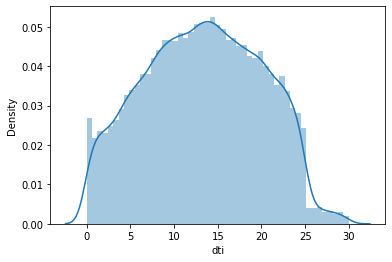

In [86]:
print(loan_df.dti.describe())
sns.distplot(loan_df.dti)
plt.show()

- From the above distribution plot, we can figure out that 50 percentage of LC customers have debt to income ratio of less than **13.37**.<br>
- There is a sudden fall in the above distplot after dti value of 25. It indicates that LC has issued very few loans to the segment of customer with dti above **25**.<br>
- **0** to **30** seems the range of dti of LC customers. We can already sort of guess that LendingClub applied a cap of 30% to the debt to income ratio (only give out loans if borrower's debt to income ratio is less than 30%). 

From **dti**, let's derive a categorical income variable with 3 fixed sized bins and call it **dti_category**.

In [87]:
loan_df['dti_category'] = pd.cut(loan_df.dti, [0,10,20,30], labels=['0-10%', '10-20%', '20-30%'], include_lowest=True)

In [88]:
loan_df['dti_category'].value_counts()

10-20%    18441
0-10%     12935
20-30%     7201
Name: dti_category, dtype: int64

dti_category
0-10%     0.126092
10-20%    0.151348
20-30%    0.167338
Name: default, dtype: float64


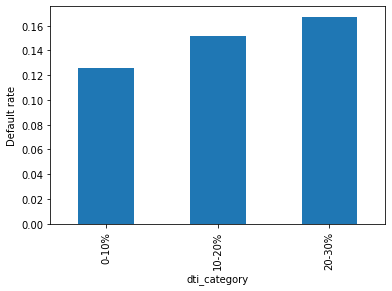

In [89]:
print(loan_df.groupby('dti_category')['default'].mean())
loan_df.groupby('dti_category')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

From previously we know that the average default rate of ALL loans is 14.59%. As we can see above, there seems to be quite a **clear relationship** that **low debt to income ratio** of 0-10% corresponds to **lower average default rate** (12.61%) and **high debt to income ratio** of 20-30% corresponds to a **higher average default rate** (16.73%). A medium debt to income ratio of 10-20% has an average default rate of 15.13%.

### 2.18 Month of reported earliest credit line (earliest_cr_line)

This variable indicates the month in which the borrower's earliest reported credit line was opened.

In [90]:
loan_df.earliest_cr_line.describe()

count      38577
unique       524
top       Oct-99
freq         360
Name: earliest_cr_line, dtype: object

We do not have any missing values in this column.

In [91]:
loan_df.earliest_cr_line.unique()

array(['Jan-85', 'Apr-99', 'Nov-01', 'Feb-96', 'Nov-04', 'Jul-05',
       'Jan-07', 'Apr-04', 'Sep-04', 'Jan-98', 'Oct-89', 'Jul-03',
       'May-91', 'Sep-07', 'Oct-98', 'Aug-93', 'Oct-03', 'Jan-01',
       'Nov-97', 'Feb-83', 'Jul-85', 'Apr-03', 'Jun-01', 'Feb-02',
       'Aug-84', 'Nov-06', 'Dec-87', 'Nov-81', 'Apr-05', 'Oct-07',
       'Dec-00', 'Apr-07', 'Jan-03', 'Mar-94', 'Sep-98', 'Jun-04',
       'Nov-95', 'Jul-99', 'Jun-95', 'Sep-92', 'Jan-02', 'Apr-92',
       'Oct-06', 'May-00', 'Dec-98', 'Dec-04', 'Oct-00', 'May-02',
       'May-06', 'Jul-02', 'Jul-06', 'May-97', 'Oct-05', 'Apr-95',
       'Oct-02', 'Jan-00', 'Apr-00', 'Dec-94', 'Sep-05', 'Dec-84',
       'Dec-99', 'Nov-03', 'Jun-89', 'Jun-03', 'Oct-96', 'May-03',
       'Jun-02', 'Jun-07', 'Dec-96', 'Sep-02', 'Jan-86', 'May-98',
       'Jan-97', 'Jun-05', 'Feb-90', 'Mar-04', 'Jul-95', 'Aug-94',
       'Jun-92', 'Mar-97', 'Apr-06', 'Apr-90', 'Aug-99', 'Sep-00',
       'Feb-01', 'Dec-88', 'Feb-99', 'Dec-91', 'Aug-00', 'Oct-

Here we have years less than **1969** as well. So lets convert this column data into proper format before analysing it.

In [92]:
#converting two digit year to four digit year with logic
loan_df['earliest_cr_line']=loan_df['earliest_cr_line'].apply(lambda x:x[:4]+'20'+x[-2:] if int(x[-2:])<20
                                                              else x[:4]+'19'+x[-2:])

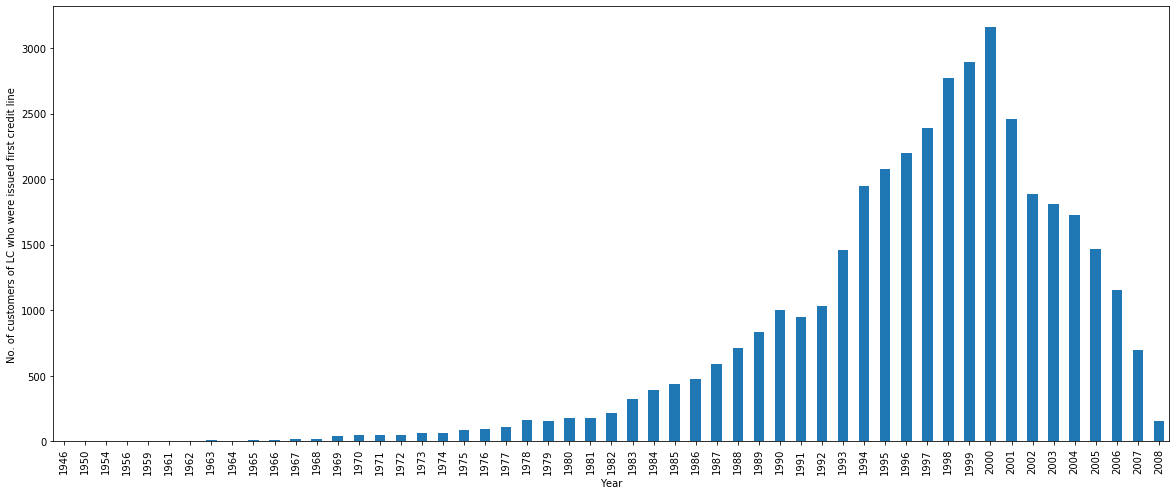

In [93]:
plt.figure(figsize=(20, 8))
pd.to_datetime(loan_df.earliest_cr_line,format='%b-%Y').dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Year')
plt.ylabel('No. of customers of LC who were issued first credit line')
plt.show()

From the above plot, we can notice that majority of the customers of LC have been issued their respective first credit lines after the year **1980**.

In [94]:
loan_df['ecl_year']=pd.to_datetime(loan_df.earliest_cr_line,format='%b-%Y').dt.year

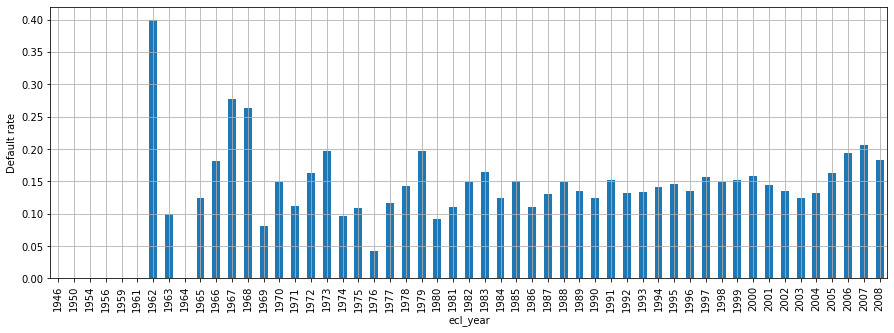

In [95]:
plt.figure(figsize=(15,5))
loan_df.groupby('ecl_year').default.mean().plot.bar(grid=True)
plt.ylabel('Default rate')
plt.show()

From above bar plot, we can deliberate that the percentage of loans with charged off among people with earliest credit line issued in different years remains almost between 10% to 20%. Those with higher percentage have low count of people. **Hence we can not obtain any significant insight from earliest_cr_line** column.

### 2.19 No. of inqueries in last 6 months (inq_last_6mths)

The variable indicates the number of inquiries in past 6 months (excluding auto and mortgage inquiries).

In [96]:
loan_df.inq_last_6mths.describe()

count    38577.000000
mean         0.871737
std          1.071546
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

We do not have any missing values in this column.

In [97]:
loan_df.inq_last_6mths.value_counts()

0    18709
1    10660
2     5654
3     2983
4      316
5      144
6       63
7       34
8       14
Name: inq_last_6mths, dtype: int64

From the above, we get that majority of LC customers have not made **more than 1** loan inqueries in the past 06 months. This feature of column can be utilized in bivariate analysis.

Another common factor financial institutions use to access borrowers is number of inquiries that borrower authorized the financial instituion for credit purposes (excluding auto and mortage inquiries). If the number of inquiries during a short period is high, it can be an indication that borrower is in hardship and is in need of cash. Let's check out this variable. 

In [98]:
loan_df.inq_last_6mths.value_counts()

0    18709
1    10660
2     5654
3     2983
4      316
5      144
6       63
7       34
8       14
Name: inq_last_6mths, dtype: int64

We create a **inq_last_6mths_category** column which takes only 3 values (0 inquiry, 1 inquiry, more than 1 inquiry)

In [99]:
loan_df['inq_last_6mths_category'] = pd.cut(loan_df.inq_last_6mths, [0, 0.1, 1, 1000], 
                                            labels=['0', '1', '2 or more'], include_lowest=True)

inq_last_6mths_category
0            0.121866
1            0.157317
2 or more    0.181364
Name: default, dtype: float64


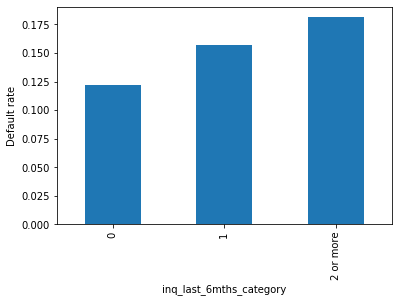

In [100]:
print(loan_df.groupby('inq_last_6mths_category')['default'].mean())
loan_df.groupby('inq_last_6mths_category')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

As seen above, there is a **positive relationship** between **No. of inquiries in last 6 months** and tendency to default. Average default rates of those without any inquiries is 12.19%, average defaults rates of those with 1 inquiry is 15.73% and average default rate for those with more than 1 inquiry is 18.14%.

### 2.20 No. of open credit lines (open_acc)

This number indicates the no. of open credit lines in the borrower's credit file.

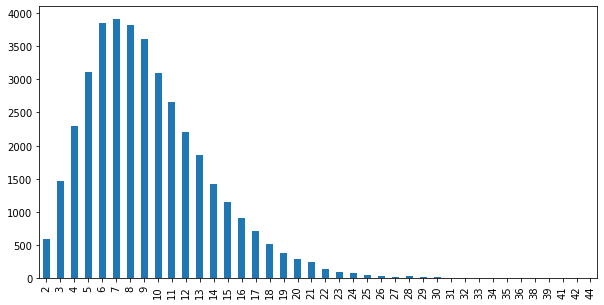

count    38577.000000
mean         9.275423
std          4.401588
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64


In [101]:
plt.figure(figsize=(10, 5))
loan_df.open_acc.value_counts().sort_index().plot.bar()
plt.show()
print(loan_df.open_acc.describe())

From the above, we can derive the following:
- that most of LC customers have no. of currently open credit lines in the range of **5 to 10**.<br>
- the bar graph almost falls after **25** creditlines.<br>
- this column is being monitored by LC even after issuance of loans. The range of this column is starting from 2. So, if we subtract 1 (the LC issued loan/creditline) from the above, it means that LC only issues loans to those customers with existing credit line(s).

From above, we can see that the 25th percentile of number of credit lines is 6, median of number of credit lines is 9, 75th percentile is 12. Reasonably, consider a normal person will have 1-2 mortgage loan, auto loan, student loan and credit card loan. So number of credit lines may not necessarily be a bad thing unless the number of them is too extreme. 

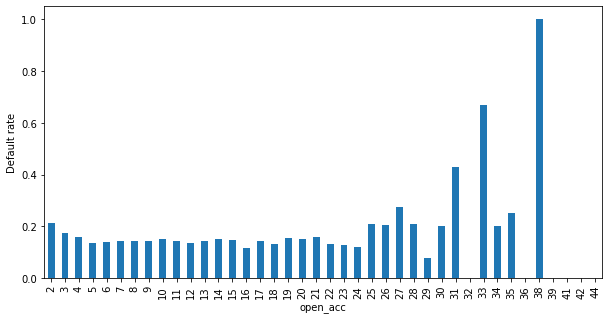

In [102]:
plt.figure(figsize=(10,5))
loan_df.groupby('open_acc')['default'].mean().plot.bar()
plt.ylabel('Default rate')
plt.show()

As seen above, some of the highest default rates corresponds to extremely high number of open credit lines. Interestingly borrowers with only 2-3 credit lines also have higher than average default rates, which suggests that a lack of credit (low number of credit lines) may not indicate that the loan is less risky, which is quite possible because a lack of credit lines may imply that these borrowers could have been rejected credit elsewhere. Let's create an **open_acc_category** which takes only 3 values (**Few** for less than 5 open credit lines, **Normal** for 5 to 20 credit lines, **High** for more than 20 credit lines).

open_acc_category
2-4     0.171553
5-20    0.142200
> 20    0.160274
Name: default, dtype: float64


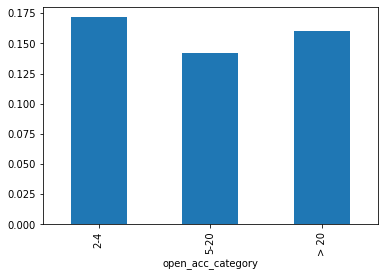

In [103]:
loan_df['open_acc_category'] = pd.cut(loan_df.open_acc, [0,4,20,1000], 
                                      labels=['2-4', '5-20', '> 20'], include_lowest=True)
print(loan_df.groupby('open_acc_category')['default'].mean())
loan_df.groupby('open_acc_category')['default'].mean().plot.bar()
plt.show()

As seen above, there's no positive relationship between number of credit lines and tendency to default. Those with very few open credit lines (2 to 4) has the highest average default rate at 17.16%. Those with extreme number of open credit lines (above 20) also has a higher than average default rate at 16.03%.

### 2.21 Total credit lines (total_acc)

This is the total number of credit lines currently in the borrower's credit file.

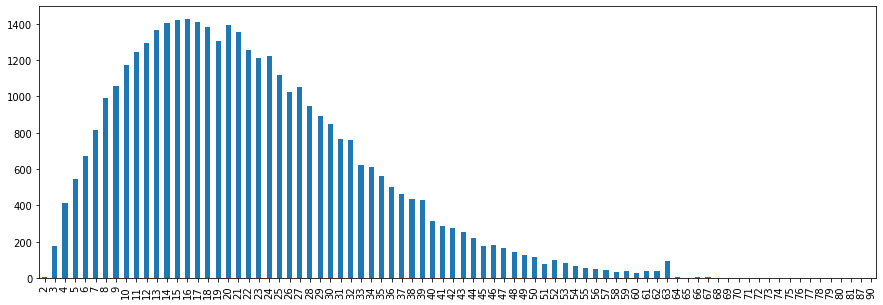

In [104]:
plt.figure(figsize=(15, 5))
loan_df.total_acc.value_counts().sort_index().plot.bar()
plt.show()

From the open and total credit line columns, we may notice that the count of customers is starting from 2 in both the columns. The same indicates that LC only issues loans to those customers who have atleast one **open credit line**.

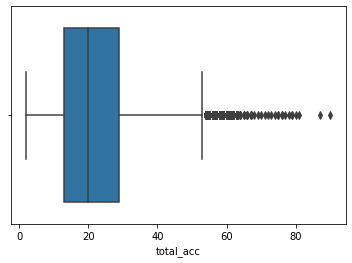

count    38577.000000
mean        22.052648
std         11.425861
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64


In [105]:
sns.boxplot(loan_df.total_acc)
plt.show()
print(loan_df.total_acc.describe())

From the above, we see that majority of LC customers have total no. of credit lines in their files in the range of **13 to 29**.<br>

Lets divide this column into three categories viz. L (min to 13), LM (13 to 20), HM (20 to 29) & H (29 to max) and then checkout the corresponding default rates.

In [106]:
loan_df['total_creditline_category']=pd.cut(loan_df.total_acc,[0,13,20,29,90],['L','LM','HM','H'])

total_creditline_category
(0, 13]     0.160731
(13, 20]    0.146690
(20, 29]    0.134279
(29, 90]    0.141860
Name: default, dtype: float64


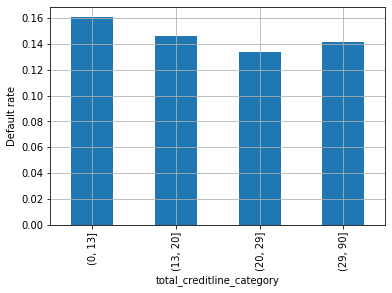

In [107]:
print(loan_df.groupby('total_creditline_category').default.mean())
loan_df.groupby('total_creditline_category').default.mean().plot.bar(grid=True)
plt.ylabel('Default rate')
plt.show()

From the above plot, we found weak negative relation between default rate and total credit lines, however the difference does not seem too much.

### 2.22 Loan Default Status

This is a derived column indicating the default status of the loan. **0:Fully Paid** and **1:Charged Off**

0    32950
1     5627
Name: default, dtype: int64


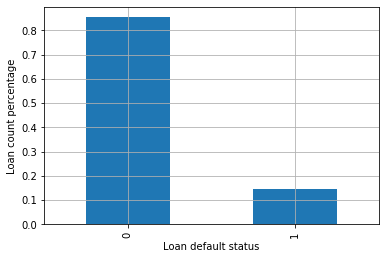

In [108]:
print(loan_df.default.value_counts())
loan_df.default.value_counts(normalize=True).plot.bar(grid=True)
plt.xlabel('Loan default status')
plt.ylabel('Loan count percentage')
plt.show()

From the above plot, we konw that approximately **15%** of LC loans have been defaulted while **85%** of the loans have been fully paid.

## Section 3: Bivariate Analysis

### 3.1 Average Default Rate for each Sub Grade by Loan Tenure

From https://www.lendingclub.com/foliofn/rateDetail.action we understand that loan grade takes into account credit score and several indicators of credit risk from credit report and loan application. We also know that interest rates are adjusted based on the loan grade.

Let's look at the default rate of sub grades for different loan tenures.

<Figure size 1440x720 with 0 Axes>

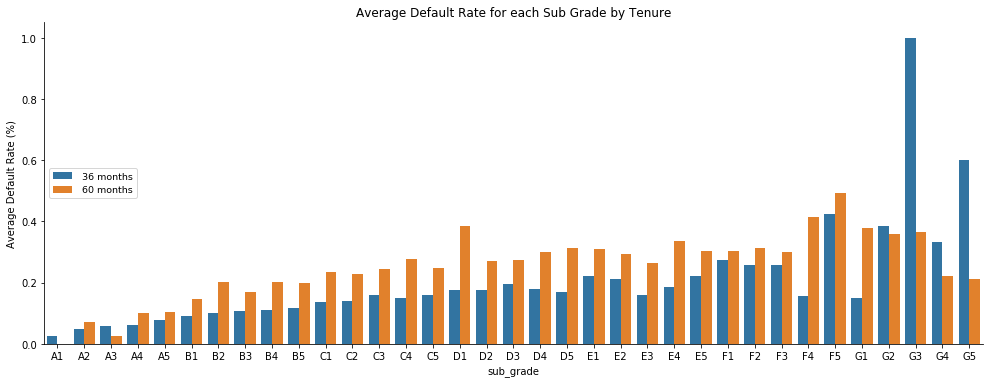

In [109]:
list_subgrades = list(loan_df.sub_grade.unique())
list_subgrades.sort()

plt.figure(figsize=(20, 10))
g = sns.catplot(x='sub_grade', y='default', hue='term', kind='bar', 
                    data=loan_df, legend=False, order=list_subgrades, ci=None)
g.fig.set_figwidth(15)
g.fig.set_figheight(5)

plt.title('Average Default Rate for each Sub Grade by Tenure')
plt.ylabel('Average Default Rate (%)')
plt.legend(loc='center left', fontsize=9.5)
plt.show()

Average Default Rate for 60 months tenure is quite consistently higher for each Sub Grade except for few of the best Sub Grades (i.e A1 and A3) and the worst Sub Grades (i.e G2-G5), suggesting that by using both variables (sub grade and tenure), we could explain default rates even better. <u>In general, average default rate increases as we go from good sub grades to worse sub grades</u>. This pattern does not apply to the best sub grades and the worst sub grades as the best sub grades and the worst sub grades are more indifferent to tenure. A possible explanation is that the best sub grades have very good credit profile and a longer tenure may have a smaller/negligible impact on the default rate. There are very few loans given to the worst sub grades (G1-G5) so results could be a little noisy for these groups.

### 3.2 Average Default Rate for each Sub Grade by Loan Amount

From univariate analysis we find that loans greater than 15k have 18.7% average default rate compared to those 15k or below which have less than 14% average default rate. Let's analyze the default rate for 2 category of loan amount (those 15k and below and those above 15k) for each Sub Grade bucket.  

In [110]:
loan_df['loan_amnt_two_category'] = pd.cut(loan_df.loan_amnt, [0,15000,35000], 
                                      labels=['15k and below', 'Above 15k'])

<Figure size 1440x720 with 0 Axes>

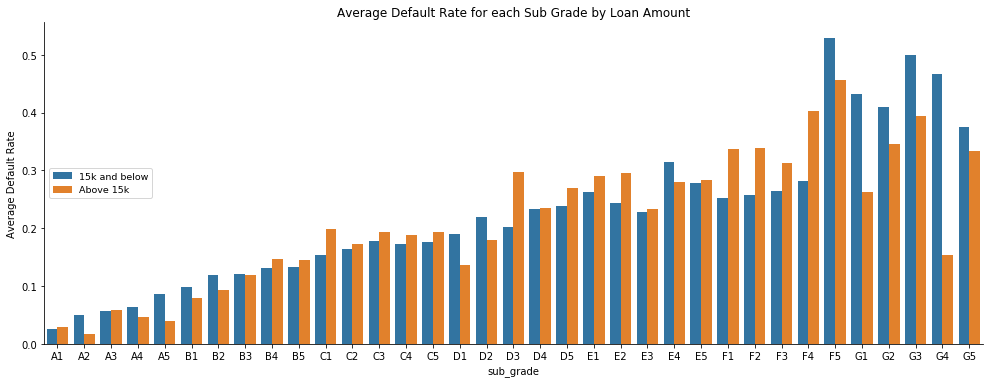

In [111]:
plt.figure(figsize=(20, 10))
g = sns.catplot(x='sub_grade', y='default', hue='loan_amnt_two_category', kind='bar', 
                    data=loan_df, legend=False, order=list_subgrades, ci=None)
g.fig.set_figwidth(15)
g.fig.set_figheight(5)

plt.ylabel('Average Default Rate')
plt.legend(loc='center left', fontsize=9.5)
plt.title('Average Default Rate for each Sub Grade by Loan Amount')
plt.show()

When we start from the highest grade A1 and move lower, those with above 15k loan amount actually had a lower default rate than those with 15k loan amount or lower. It is only until B4 Sub Grade then we can observe that the average default rate for loan amounts bigger than 15k quite consistently overtaking the average default rate for loan amounts 15k or lower and the pattern generally persists further till subgrade F4 (grade G1-G5 actually had too little data for us to pay attention to).

The above observation suggests that for loans with the stronger credit (A1-A5, B1-B3), perhaps 15k should not be used as a cut off. We could set the cut off amount higher for stronger credit (i.e stronger credit should not be penalized in terms of interest rates until a higher cut off amount). However, <u>for loans with weaker credit (B4 onwards), it is generally the case that loan amounts above 15k have higher default rate than those 15k or below <u/> and we could penalize these loans in terms of higher interest rates to compensate for the higher default probability.

### 3.3 Average Default Rate for each Grade by Loan Amount

Let's break down the Loan Amount further to few more categories (especially for loan amounts > 15k) to see the impact further. But for this time we will use Grade instead of the Sub Grade (Grades have much fewer categories) so as not to complicate the visualization.

In [112]:
loan_df['loan_amnt_three_category'] = pd.cut(loan_df.loan_amnt, [0,15000,25000, 35000], 
                                      labels=['15k and below', '15-25k', 'Above 25k'])

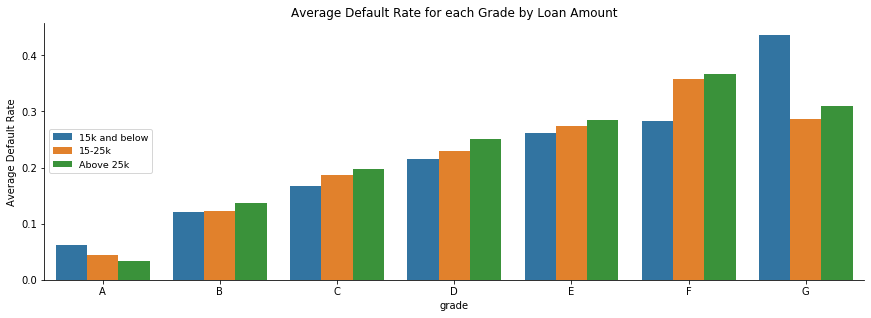

In [113]:
list_grades = list(loan_df.grade.unique())
list_grades.sort()

g = sns.catplot(x='grade', y='default', hue='loan_amnt_three_category', kind='bar', 
                    data=loan_df, legend=False, order=list_grades, ci=None)
g.fig.set_figwidth(13)
g.fig.set_figheight(4)

plt.ylabel('Average Default Rate')
plt.legend(loc='center left', fontsize=9.5)
plt.title('Average Default Rate for each Grade by Loan Amount')
plt.show()

Here we get a similar conclusion that <u>in general when loan amount increases, the average default rate for each grade increases</u> (except for Grade A where average defaults are very low 5-6% or less and for Grade G where number of loans given were very few). We do see for Grades B to F, the average default rates for loans above 25k are always higher than average default rates for loans between 15 to 25k, and the average default rates for loans 15-25k are always higher than average default rates for loans less than 15k. We would suggest that for loan grades B or higher, we should apply a higher interest rate charge to loans 15-25k compared to loans 15k and below, and a higher interest charge to loans above 25k compared to loans 15-25k.

### 3.4 Average Default Rate for each Grade by Region

In univariate analysis, we observe higher average default rate for borrowers from the West region. Let's plot the average default rate for each sub grade by region to see if these higher risk borrowers are properly captured by their sub grade.

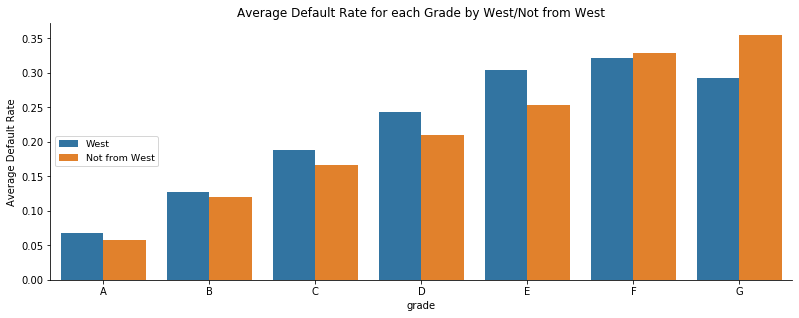

In [114]:
loan_df['west'] = loan_df['region'].apply(lambda x: x if x == 'West' else 'Not from West')

g = sns.catplot(x='grade', y='default', hue='west', kind='bar', 
                    data=loan_df, legend=False, order=list_grades, ci=None)
g.fig.set_figwidth(12)
g.fig.set_figheight(4)

plt.ylabel('Average Default Rate')
plt.legend(loc='center left', fontsize=9.5)
plt.title('Average Default Rate for each Grade by West/Not from West')
plt.show()

It suggests that even after taking into account loan grade, borrowers from the West region are still more likely to default compared to borrowers who are not from the West Region.

### 3.5 Average Default Rate for Different Loan Tenure by Region

Let's plot the average default rate for different loan tenure by region. This will provide a clue if higher average rate of default in the West region is due to different loan tenure.

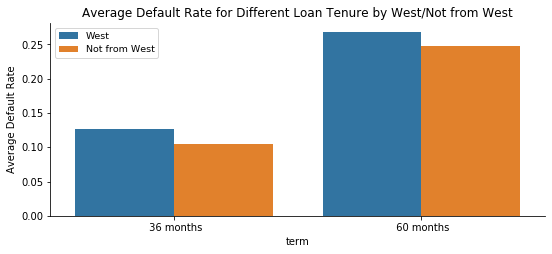

In [115]:
g = sns.catplot(x='term', y='default', hue='west', kind='bar', 
                    data=loan_df, legend=False, ci=None)
g.fig.set_figwidth(8)
g.fig.set_figheight(3)

plt.ylabel('Average Default Rate')
plt.legend(loc='upper left', fontsize=9.5)
plt.title('Average Default Rate for Different Loan Tenure by West/Not from West')
plt.show()

Again, after taking into account loan tenure, borrowers from the West region are still more likely to default as compared to borrowers not from the West region. 

### 3.6 Average Default Rate for Different Loan Amount by Region

Let's plot the average default rate for different loan amount by region. This will provide a clue if higher average default rate for borrowers from the West Region could be due to higher loan amount (since we know that high loan amounts are more prone to default).

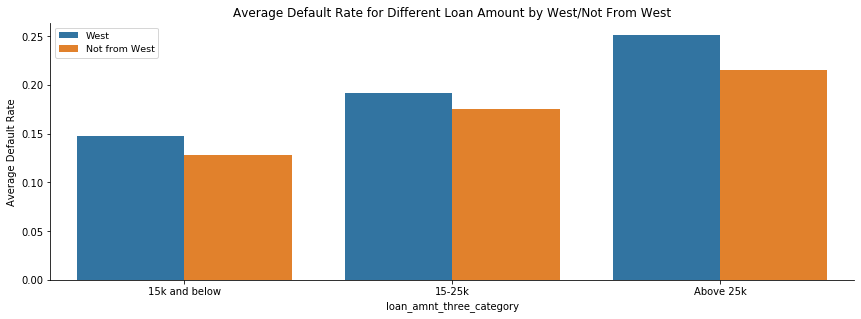

In [116]:
g = sns.catplot(x='loan_amnt_three_category', y='default', hue='west', kind='bar', 
                    data=loan_df, legend=False, ci=None)
g.fig.set_figwidth(13)
g.fig.set_figheight(4)

plt.ylabel('Average Default Rate')
plt.legend(loc='upper left', fontsize=9.5)
plt.title('Average Default Rate for Different Loan Amount by West/Not From West')
plt.show()

Again, after taking into account different loan amounts, borrowers from the West region are still more likely to default as compared to borrowers not from the West region. We suggest that LC should further investigate into reasons why borrowers from the West region have a higher average default rate even after taking into account loan amount, grade and loan tenure.

### 3.7 Average Default Rate for different Loan Amount by Term

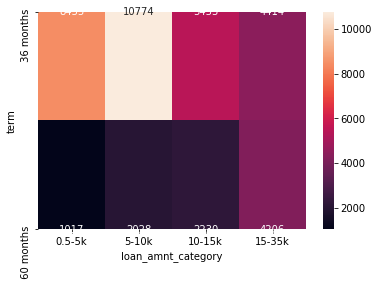

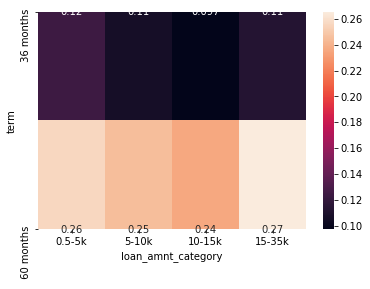

In [117]:
sns.heatmap(pd.pivot_table(data=loan_df,index='term',columns='loan_amnt_category',
                           values='default',aggfunc='count'),annot=True,fmt='.0f')
plt.show()
sns.heatmap(pd.pivot_table(data=loan_df,index='term',columns='loan_amnt_category',values='default'),annot=True)
plt.show()

From the above heatmap, we note that there are sufficient counts in each of the sub-categories and hence we can justifiably compare the default rate in each. We can deliberate that overall default rate is higher in 60 months tenure loans. Upon further sub-categorizing them based on different loan amounts, we do see that lower (0.5-5k) and higher (15-35k) loan amounts are relatively more risky. LC should impose more interest rates in these loans.

### 3.8 Average Default Rate for different Loan Amount by Annual Income

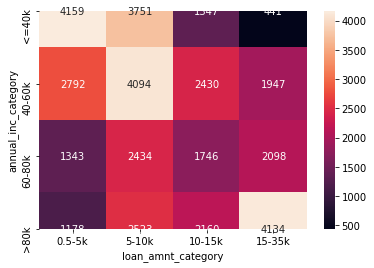

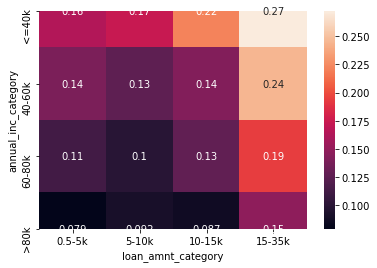

In [118]:
sns.heatmap(pd.pivot_table(data=loan_df,index='annual_inc_category',columns='loan_amnt_category',
                           values='default',aggfunc='count'),annot=True,fmt='.0f')
plt.show()
sns.heatmap(pd.pivot_table(data=loan_df,index='annual_inc_category',columns='loan_amnt_category',values='default'),annot=True)
plt.show()

We note that borrowers with annual income less than 40K and who have borrowed loan amount in the range of 15-35K have massive **27%** default rate. LC should keep track on giving high loan amounts to class of people with low annual incomes.

### 3.9 Average Default Rate for different Loan Amount by Employment Length

In [119]:
#function to convert employment length to int 
def func(x):
    if str(x)=='nan':
        return x
    else:
        year=''
        for i in x:
            if i.isdigit():
                year+=i
        return int(year) 

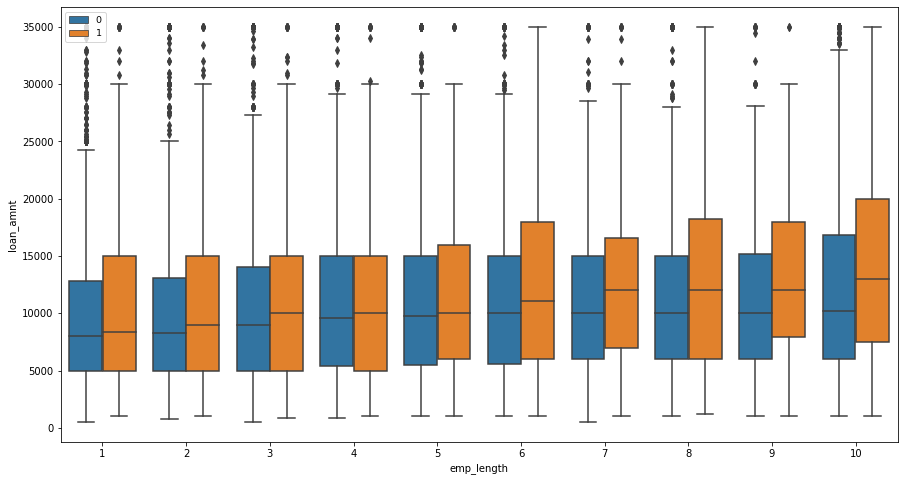

In [120]:
plt.figure(figsize=(15,8))
sns.boxplot(x=loan_df.emp_length.apply(func),y=loan_df.loan_amnt,order=[1,2,3,4,5,6,7,8,9,10],hue=loan_df.default)
plt.legend(loc='upper left', fontsize=9.5)
plt.show()

From the above box plot, we know that till the borrowers with 5 years of experience, we do not see much difference between median value of issued loan amount for default and fully paid loan, however for borrowers with more than 5 years of experience, we can clearly see much difference in the median values of the issued loans for default and fully paid loans. To mitigate the same, LC may charge higher interest rates for higher amount loans to the borrowers with 5+ years of employment length.

### 3.10 Average Default Rate for different Interest Rate by Annual Income Category

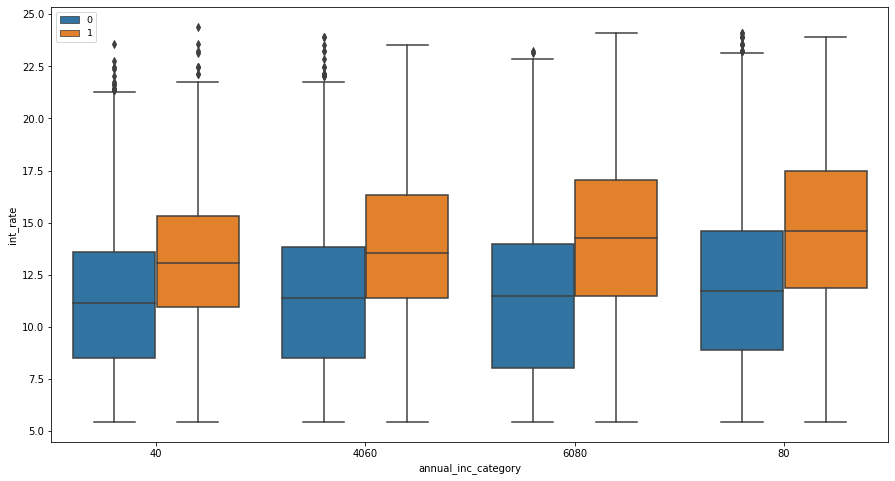

In [121]:
plt.figure(figsize=(15,8))
sns.boxplot(y=loan_df.int_rate,x=loan_df.annual_inc_category.apply(func),hue=loan_df.default)
plt.legend(loc='upper left', fontsize=9.5)
plt.show()

From the above, we note that fully paid loans have been charged with consistently low interest rate while that for charged off loans, higher interest rates have been charged to customers with higher income. LC may reduce down the interest rate for higher income customers to bring down the default rate since more customers income means better security to LC.

## Section 4: Charts for Power Point Presentation

In [122]:
loan_df['int_rate_category'] = pd.cut(loan_df['int_rate'], [5.4, 10, 15, 20, 24.4], 
                      labels=['5.42-10%', '10-15%', '15-20%', '20-24.4%'])

Categorize employment length variable to take values 3 years and below, 4-9 years, 10 years and above and N/A values.

In [123]:
loan_df['emp_length'] = loan_df['emp_length'].fillna('100') 

def emp_length(length):
    if length[:3] == '10+':
        return 10
    elif length[0] == '<':
        return 0
    elif length == '100':
        return 100
    else:
        return int(length[0])
    
loan_df['emp_length'] = loan_df['emp_length'].apply(emp_length)
loan_df['emp_length_category'] = pd.cut(loan_df['emp_length'], [0, 3, 9, 10, 100], 
                      labels=['<=3 yrs', '4-9 yrs', '10+ yrs', 'N/A'],
                      include_lowest=True)


In [124]:
# user-defined functions for chart generation


#convert value counts of each category to percentage terms
def to_pct(var_name, top=10):  
    if var_name == 'purpose':
        return loan_df[var_name].value_counts(sort=True).head(n=top) / len(loan_df) * 100
    elif var_name == 'grade' or var_name =='sub_grade':
        return loan_df[var_name].value_counts(sort=False).sort_index() / len(loan_df) * 100
    return loan_df[var_name].value_counts(sort=False) / len(loan_df) * 100


#generate average default rate for each category
def get_def_rate(var_name, ascending=False, top=5):           
    if var_name == 'purpose':
        return loan_df.groupby(var_name)['default'].mean().sort_values(ascending=ascending).head(n=top) * 100
    return loan_df.groupby(var_name)['default'].mean() * 100


#Function to add labels in chart
def autolabel(ax, offset):                  
    for rect in ax.patches:
        height = rect.get_height()
        #ypos = rect.get_y() + height/2
        ypos = height + offset
        ax.text(rect.get_x() + rect.get_width()/2., ypos, round(height, 1), ha='center', va='top')

In [125]:
#variable dictionary to plot Chart Title

var_dict = {'loan_amnt_category': 'Loan Amount', 'term': 'Loan Tenure', 'region': 'Region', 
            'purpose': 'Top 10 Loan Purpose', 'annual_inc_category': 'Annual Income', 
            'verification_status': 'Income Verification Status', 'dti_category': 'Debt-to_Income Ratio', 
            'emp_length_category': 'Employment Length', 'home_ownership': 'Home Ownership Status',
            'int_rate_category': 'Interest Rate', 'grade': 'Loan Grade',
            'sub_grade': 'Loan Sub Grade'
            }

Text(0.5, 0.98, 'Percentage of Loans in Each Loan Attribute Category')

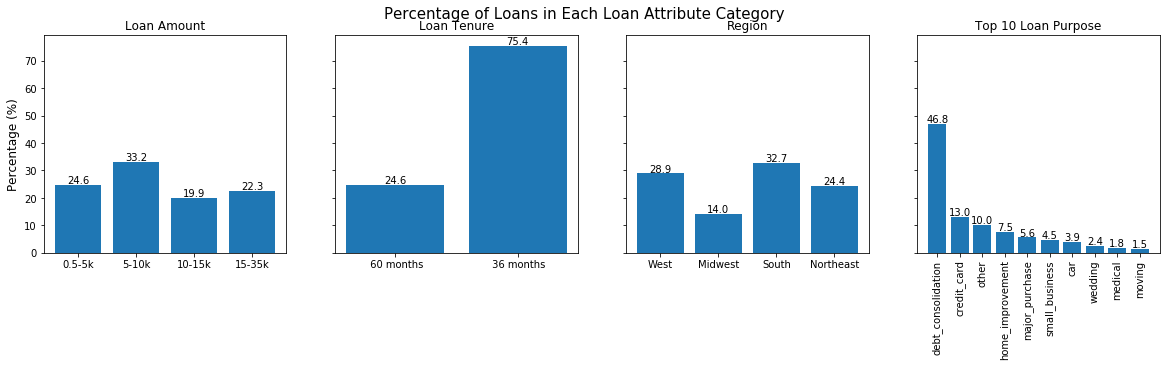

In [126]:
# Create first percentage chart

var_list = ['loan_amnt_category', 'term', 'region', 'purpose']

first_pct_plot = []

for i in range(len(var_list)):
    first_pct_plot.append(to_pct(var_list[i]))

f, axs = plt.subplots(1, len(var_list), sharey=True, figsize=(20,4))

for i in range(len(axs)):
    if i == 0:
        axs[i].set_ylabel('Percentage (%)', fontsize=12)
    axs[i].bar(first_pct_plot[i].index, first_pct_plot[i].values)
    axs[i].set_title(var_dict[var_list[i]])
    autolabel(axs[i], 3.5)

axs[3].tick_params(labelrotation=90)
plt.suptitle('Percentage of Loans in Each Loan Attribute Category', fontsize=15)

As above:
- 22.3% of loans are above 15k and the rest (77.7%) are below 15k.
- 75.4% of loans are 36-month loan and 24.6% are 60-month loan.
- Most loans are in South region (32.7%)
- Majority of loans (46.8%) are used for debt consolidation purpose.

Text(0.5, 0.98, 'Average Default Rate for Different Loan Attributes')

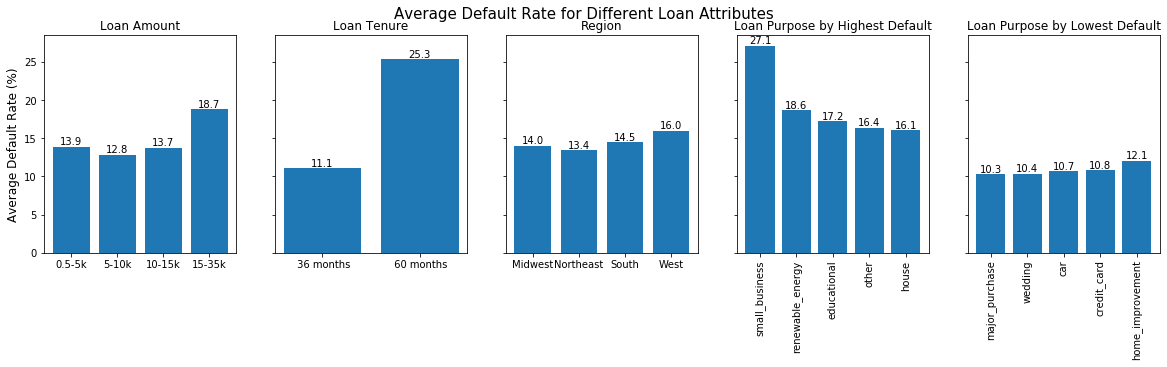

In [127]:
# Create first default rate chart

var_list = ['loan_amnt_category', 'term', 'region', 'purpose', 'purpose']

first_def_rate_plot = []

for i in range(len(var_list) - 2):       
    first_def_rate_plot.append(get_def_rate(var_list[i]))

# use separate function parameter for 'purpose' variable
first_def_rate_plot.append(get_def_rate(var_list[3], ascending=False))
first_def_rate_plot.append(get_def_rate(var_list[4], ascending=True))

f, axs = plt.subplots(1, len(var_list), sharey=True, figsize=(20,4))

for i in range(len(axs)):
    if i == 0:
        axs[i].set_ylabel('Average Default Rate (%)', fontsize=12)
    axs[i].bar(first_def_rate_plot[i].index, first_def_rate_plot[i].values)

    if i < 3: #set title for loan purpose separately
        axs[i].set_title(var_dict[var_list[i]])
    autolabel(axs[i], 1.3)

axs[3].set_title('Loan Purpose by Highest Default')
axs[4].set_title('Loan Purpose by Lowest Default')
axs[3].tick_params(labelrotation=90)    
axs[4].tick_params(labelrotation=90)    
plt.suptitle('Average Default Rate for Different Loan Attributes', fontsize=15)


As above:
- Borrowers who have taken out a bigger loan (above 15k) have a higher default rate (18.7%) than those who have taken out a smaller loan.
- A 60-month loan has a much higher average default rate (25.3%) than a 36-month loan (11.1% default rate)
- Borrowers from the West region has a higher than average default rate of 16.0%.
- Borrowers who take a loan for small business purpose has a much higher average default rate of 27.1, while borrowers who take a loan for credit card purpose has a lower than average default rate of 10.8%. 

Text(0.5, 0.98, 'Percentage of Loans in Each Financial Profile Category')

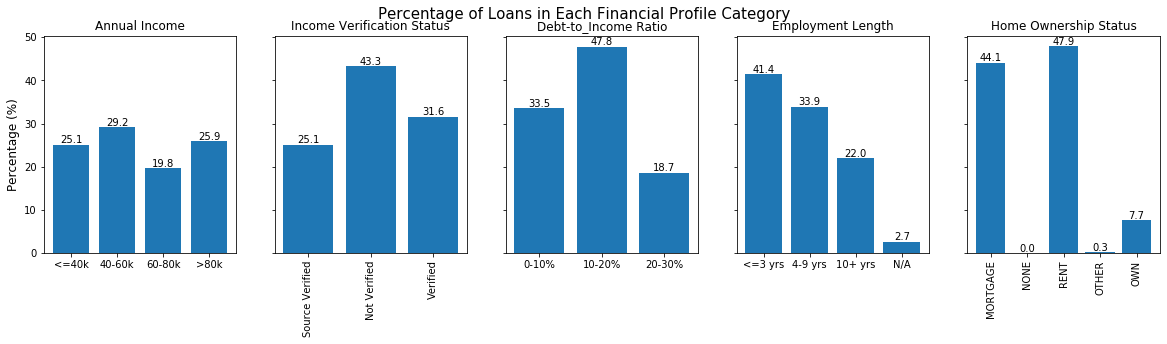

In [128]:
# Create second percentage chart

var_list = ['annual_inc_category', 'verification_status', 'dti_category', 'emp_length_category', 'home_ownership']

second_pct_plot = []

for i in range(len(var_list)):
    second_pct_plot.append(to_pct(var_list[i]))

f, axs = plt.subplots(1, len(var_list), sharey=True, figsize=(20,4))

for i in range(len(axs)):
    if i == 0:
        axs[i].set_ylabel('Percentage (%)', fontsize=12)
    axs[i].bar(second_pct_plot[i].index, second_pct_plot[i].values)
    axs[i].set_title(var_dict[var_list[i]])
    autolabel(axs[i], 2.2)

axs[1].tick_params(labelrotation=90, axis='x')
axs[4].tick_params(labelrotation=90, axis='x')
plt.suptitle('Percentage of Loans in Each Financial Profile Category', fontsize=15)

As above:
- 54.3% of the borrowers earn not more than 60k.
- 43.3% of borrower's income are NOT verified by LendingClub. Other borrower's income are either verified or source verified.
- Debt-to-income ratio ranges from 0-30%. 47.8% are in the range of 10-20%.
- 41.4% of loans are given to borrowers with 3 years or less employment history. 2.7% of loans are given to borrowers without employment history.
- 47.9 % of loans are given to borrowers who RENT a home. 44.1% of loans are given to borrowers who has a MORTGAGE on their home.

Text(0.5, 0.98, 'Average Default Rate for different Financial Profile')

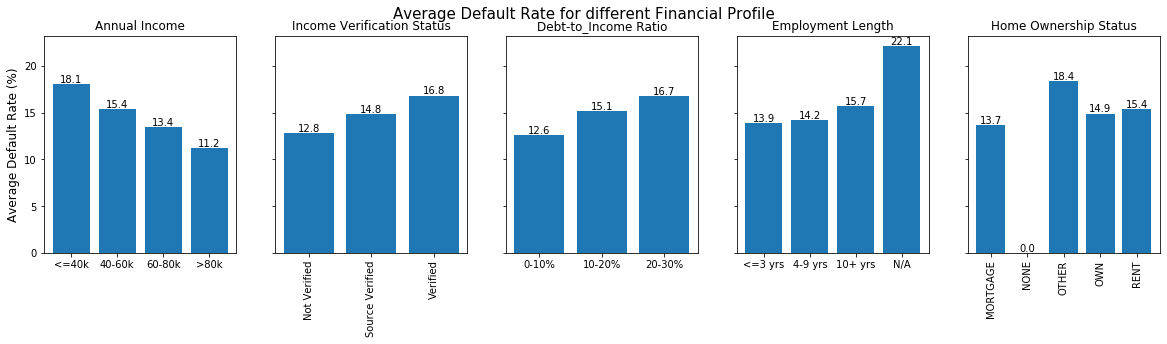

In [129]:
#create second default rate chart

second_def_rate_plot = []

for i in range(len(var_list)):       
    second_def_rate_plot.append(get_def_rate(var_list[i]))


f, axs = plt.subplots(1, len(var_list), sharey=True, figsize=(20,4))

for i in range(len(axs)):
    if i == 0:
        axs[i].set_ylabel('Average Default Rate (%)', fontsize=12)
    axs[i].bar(second_def_rate_plot[i].index, second_def_rate_plot[i].values)
    axs[i].set_title(var_dict[var_list[i]])
    autolabel(axs[i], 1.)
    
axs[1].tick_params(labelrotation=90, axis='x')
axs[4].tick_params(labelrotation=90, axis='x')
plt.suptitle('Average Default Rate for different Financial Profile', fontsize=15)



As above:
- Annual income has a clear negative linear relationship with average default rate. The higher the annual income the lower the average default rate.
- Borrowers whose income are Not Verified has the lowest average default rate at 12.8%, while borrowers whose income even though verified, has a higher average default rate at 16.8%
- Debt-to-income has a clear positive linear relationship with average default rate. The higher the debt-to-income ratio, the higher the average default rate.
- Borrowers who dont have an employment length history (possibly unemployed) have a high average default rate at 22.1%. Surprisingly, borrowers who are only employed for 3 years or less have a lower average default rate than borrowers who are employed for 10 years or more.
- Borrowers who Rent a place have a higher average default rate (15.4%) than borrowers who has a mortgage on their home (13.7% average default rate).

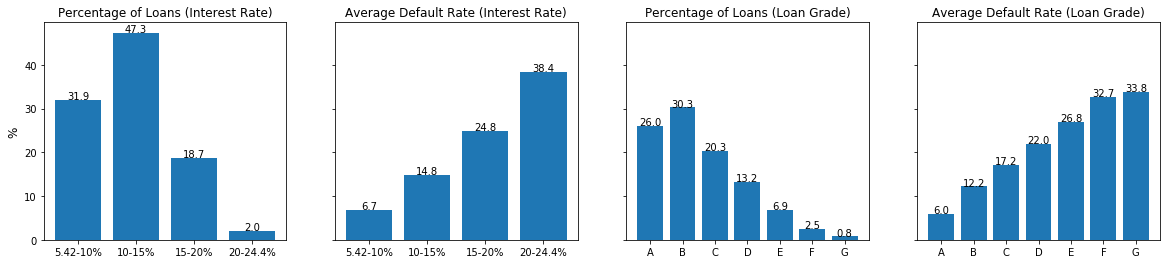

In [130]:
# Create percentage chart and default rate chart for interest rate and loan grade category

var_list = ['int_rate_category', 'grade']

third_pct_plot = []
third_def_rate_plot = []

for i in range(len(var_list)):
    third_pct_plot.append(to_pct(var_list[i]))
    third_def_rate_plot.append(get_def_rate(var_list[i]))
    
f, axs = plt.subplots(1, len(var_list) * 2, sharey=True, figsize=(20,4))

for i in range(len(var_list)):
    if i == 0:
        axs[i].set_ylabel('%', fontsize=12)
    axs[2*i].bar(third_pct_plot[i].index, third_pct_plot[i].values)
    axs[1 + 2*i].bar(third_def_rate_plot[i].index, third_def_rate_plot[i].values)
    autolabel(axs[2*i], 2.)
    autolabel(axs[1+ 2*i], 2.)
    axs[2*i].set_title(f'Percentage of Loans ({var_dict[var_list[i]]})')
    axs[1 + 2*i].set_title(f'Average Default Rate ({var_dict[var_list[i]]})')


As above:

1. Interest Rates
    - Majority of the loans (79.2%) approved are assigned an interest rate of 15% and below.
    - The average default rate of the loans increases when we go from lower to higher interest rates.


2. Loan Grade
    - Majority of the loans (76.6%) approved are assigned a loan grade of A-C.
    - The average default rate of the loans increases when we go from best to worst grade (Grade A to Grade G).


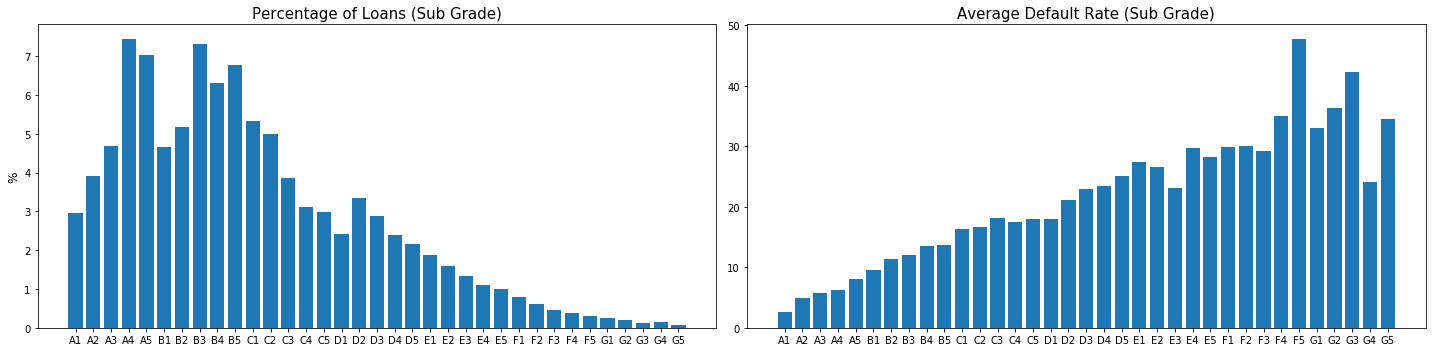

In [131]:
var_list = ['sub_grade']

fourth_pct_plot = to_pct('sub_grade')
fourth_def_rate_plot = get_def_rate('sub_grade')

f, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_ylabel('%', fontsize=12)
axs[0].set_ylabel('%', fontsize=12)
axs[0].bar(fourth_pct_plot.index, fourth_pct_plot.values)
axs[1].bar(fourth_def_rate_plot.index, fourth_def_rate_plot.values)
axs[0].set_title(f'Percentage of Loans (Sub Grade)', fontsize=15)
axs[1].set_title(f'Average Default Rate (Sub Grade)', fontsize=15)
plt.tight_layout()

Similar to Loan Grade, for Loan Sub Grade:
- Majority of the loans approved are assigned sub grade A1-C5. Very small percentage of approved loans with sub grade G1-G5.
- The average default rate of the loans increases when we go from best to worst grade (Grade A1 to Grade G5).
